In [2]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%env PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256

env: PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:256


In [3]:
import copy
import cProfile
import time

import ase.io
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import torch

from utils.combine import CombineRadial, CombineRadialSpecies, CombineSpecies
from utils.dataset import AtomisticDataset, create_dataloader
from utils.linear import LinearModel
from utils.operations import SumStructures, remove_gradient
from utils.soap import PowerSpectrum, CompositionFeatures

torch.set_default_dtype(torch.float64)

In [6]:
n_test = 10
n_train = 80

frames = ase.io.read("data/data_shuffle.xyz", f":{n_test + n_train}")

train_frames = frames[:n_train]
test_frames = frames[-n_test:]

train_energies = torch.tensor(
    [frame.info["energy"] for frame in train_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

test_energies = torch.tensor(
    [frame.info["energy"] for frame in test_frames]
).reshape(-1, 1).to(dtype=torch.get_default_dtype())

train_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype())
    for frame in train_frames
]

test_forces = [
    torch.tensor(frame.arrays["forces"]).to(dtype=torch.get_default_dtype()) 
    for frame in test_frames
]

print(f"using {n_train} training frames")

using 80 training frames


In [7]:
all_species = set()
for frame in frames:
    all_species.update(frame.numbers)

all_species = list(map(lambda u: int(u), all_species))

# HYPERS_FROM_PAPER = {
#     "interaction_cutoff": 5.0,
#     "max_angular": 9,
#     "max_radial": 12,
#     "gaussian_sigma_constant": 0.3,
#     "gaussian_sigma_type": "Constant",
#     "cutoff_smooth_width": 0.5,
#     "radial_basis": "GTO",
#     "compute_gradients": False,
#     "expansion_by_species_method": "user defined",
#     "global_species": all_species,
# }

HYPERS_SMALL = {
    "cutoff": 4.0,
    "max_angular": 3,
    "max_radial": 6,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,
    # # TODO: implement this in rascaline itself
    # "radial_per_angular": {
    #     # l: n
    #     0: 10,
    #     1: 8,
    #     2: 8,
    #     3: 4,
    #     4: 4,
    # }
}

HYPERS_RADIAL = {
    "cutoff": 5.0,
    "max_angular": 0,
    "max_radial": 10,
    "atomic_gaussian_width": 0.5,
    "cutoff_function": {"ShiftedCosine": {"width": 0.5}},
    "radial_basis": {"SplinedGto": {"accuracy": 1e-6}},
    "gradients": False,
    "center_atom_weight": 1.0,    
}

# Optimization loop, energies only

In [8]:
device = "cpu"

#if torch.cuda.is_available():
#    device = "cuda"

In [9]:
train_dataset = AtomisticDataset(train_frames, all_species, 
                                 {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, train_energies)
test_dataset = AtomisticDataset(test_frames, all_species, 
                                {"radial_spectrum": HYPERS_RADIAL, "spherical_expansion":HYPERS_SMALL}, test_energies)

In [30]:
do_gradients = False
if do_gradients is True:
    HYPERS_GRAD = copy.deepcopy(HYPERS_SMALL)
    HYPERS_GRAD["gradients"] = do_gradients
    HYPERS_RAD_GRAD = copy.deepcopy(HYPERS_RADIAL)
    HYPERS_RAD_GRAD["gradients"] = do_gradients
    train_dataset_grad = AtomisticDataset(train_frames, all_species, 
                                          {"radial_spectrum": HYPERS_RAD_GRAD, "spherical_expansion":HYPERS_GRAD}, 
                                          train_energies, train_forces)
    test_dataset_grad = AtomisticDataset(test_frames, all_species, 
                                         {"radial_spectrum": HYPERS_RAD_GRAD, "spherical_expansion":HYPERS_GRAD}, 
                                         test_energies, test_forces)
else:
    train_dataset_grad = train_dataset
    test_dataset_grad = test_dataset

In [31]:
train_dataloader = create_dataloader(
    train_dataset,
    batch_size=200,
    shuffle=True,    
    device=device,
)

train_dataloader_no_batch = create_dataloader(
    train_dataset,
    batch_size=len(train_dataset),
    shuffle=False,
    device=device,
)

train_dataloader_single_frame = create_dataloader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    device=device,
)

test_dataloader = create_dataloader(
    test_dataset,
    batch_size=200,
    shuffle=False,
    device=device,
)
if do_gradients is True:
    train_dataloader_grad = create_dataloader(
        train_dataset_grad,
        batch_size=50,
        shuffle=True,
        device=device,
    )

    train_dataloader_grad_no_batch = create_dataloader(
        train_dataset_grad,
        batch_size=len(train_dataset_grad),
        shuffle=False,
        device=device,
    )

    train_dataloader_grad_single_frame = create_dataloader(
        train_dataset_grad,
        batch_size=1,
        shuffle=False,
        device=device,
    )
    
    test_dataloader_grad = create_dataloader(
        test_dataset_grad,
        batch_size=50,
        shuffle=False,
        device=device,
    )
else:
    train_dataloader_grad_single_frame = train_dataloader_single_frame
    train_dataloader_grad = train_dataloader
    train_dataloader_grad_no_batch = train_dataloader_no_batch
    test_dataloader_grad = test_dataloader

In [32]:
def loss_mae(predicted, actual):
    return torch.sum(torch.abs(predicted.flatten() - actual.flatten()))

def loss_mse(predicted, actual):
    return torch.sum((predicted.flatten() - actual.flatten())**2)

def loss_rmse(predicted, actual):
    return np.sqrt(loss_mse(predicted, actual))

In [33]:
class CombinedPowerSpectrum(torch.nn.Module):
    def __init__(self, combiner):
        super().__init__()

        self.combiner = combiner
        self.power_spectrum = PowerSpectrum()

    def forward(self, spherical_expansion):
        combined = self.combiner(spherical_expansion)

        return self.power_spectrum(combined)

        
class MultiBodyOrderModel(torch.nn.Module):
    def __init__(
        self, 
        power_spectrum,
        composition_regularizer,
        radial_spectrum_regularizer,
        power_spectrum_regularizer,        
        optimizable_weights,
        random_initial_weights,
    ):
        super().__init__()

        self.sum_structure = SumStructures()

        # optimizable_weights = False is not very well tested ...
        assert optimizable_weights

        if composition_regularizer is None:
            self.composition_model = None
        else:
            self.composition_model=LinearModel(
            regularizer=composition_regularizer,
            optimizable_weights=optimizable_weights,
            random_initial_weights=random_initial_weights,
        )
        
        if radial_spectrum_regularizer is None:
            self.radial_spectrum_model = None
        else:
            self.radial_spectrum_model = LinearModel(
                regularizer=radial_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        if power_spectrum_regularizer is None:
            self.power_spectrum_model = None
        else:
            self.power_spectrum = power_spectrum
            self.power_spectrum_model = LinearModel(
                regularizer=power_spectrum_regularizer,
                optimizable_weights=optimizable_weights,
                random_initial_weights=random_initial_weights,
            )

        self.combiner = combiner, 
        self.optimizable_weights = optimizable_weights
        self.random_initial_weights = random_initial_weights

    def forward(self, composition, radial_spectrum, spherical_expansion, forward_forces=False):
        if not forward_forces:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)                
    
        energies, forces = None, None
        
        if self.composition_model is not None:
            energies_cmp, _ = self.composition_model(composition)
            energies = energies_cmp
            forces = None
    
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = radial_spectrum #self.sum_structure(radial_spectrum)
            energies_rs, forces_rs = self.radial_spectrum_model(radial_spectrum_per_structure, with_forces=forward_forces)
            
            if energies is None:
                energies = energies_rs  
            else:
                energies += energies_rs              
            if forces_rs is not None:
                if forces is None:
                    forces = forces_rs
                else:
                    forces += forces_rs

        if self.power_spectrum_model is not None:
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)

            energies_ps, forces_ps = self.power_spectrum_model(power_spectrum_per_structure, with_forces=forward_forces)
            if energies is None:
                energies = energies_ps
            else:
                energies += energies_ps
            if forces_ps is not None:
                if forces is None:
                    forces = forces_ps
                else:
                    forces += forces_ps
        
        return energies, forces

    def initialize_model_weights(self, composition, radial_spectrum, spherical_expansion, energies, forces=None, seed=None):
        if forces is None:
            # remove gradients if we don't need them
            spherical_expansion = remove_gradient(spherical_expansion)
            if radial_spectrum is not None:
                radial_spectrum = remove_gradient(radial_spectrum)
            
        if self.composition_model is not None:
            self.composition_model.initialize_model_weights(composition, energies, forces, seed)
        
        if self.radial_spectrum_model is not None:
            radial_spectrum_per_structure = self.sum_structure(radial_spectrum)
            self.radial_spectrum_model.initialize_model_weights(radial_spectrum_per_structure, energies, forces, seed)
        
        if self.power_spectrum_model is not None:        
            power_spectrum = self.power_spectrum(spherical_expansion)
            power_spectrum_per_structure = self.sum_structure(power_spectrum)
            self.power_spectrum_model.initialize_model_weights(power_spectrum_per_structure, energies, forces, seed)

In [34]:
# species combination only
N_PSEUDO_SPECIES = 4
combiner = CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES)

# # species combination and then radial basis combination
# N_COMBINED_RADIAL = 4
# combiner = torch.nn.Sequential(
#     CombineSpecies(species=all_species, n_pseudo_species=N_PSEUDO_SPECIES),
#     CombineRadial(max_radial=HYPERS_SMALL["max_radial"], n_combined_radial=N_COMBINED_RADIAL),
# )

# # combine both radial and species information at the same time
# combiner = CombineRadialSpecies(
#     n_species=len(all_species), 
#     max_radial=HYPERS_SMALL["max_radial"], 
#     n_combined_basis=N_COMBINED_RADIAL*N_PSEUDO_SPECIES,
# )

composition=CompositionFeatures(all_species, device=device)
power_spectrum = CombinedPowerSpectrum(combiner)

LINALG_REGULARIZER_ENERGIES = 1e-2
LINALG_REGULARIZER_FORCES = 1e-1

model = MultiBodyOrderModel(
    power_spectrum=power_spectrum, 
    composition_regularizer=[1e-10],
    radial_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    power_spectrum_regularizer=[LINALG_REGULARIZER_ENERGIES, LINALG_REGULARIZER_FORCES],
    optimizable_weights=True, 
    random_initial_weights=True,
)

In [35]:
if model.optimizable_weights:
    TORCH_REGULARIZER_COMPOSITION = 1e-8
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 1e-4
    TORCH_REGULARIZER_POWER_SPECTRUM = 1e-3
else:
    TORCH_REGULARIZER_RADIAL_SPECTRUM = 0.0
    TORCH_REGULARIZER_POWER_SPECTRUM = 0.0

In [36]:
model.to(device=device, dtype=torch.get_default_dtype())

MultiBodyOrderModel(
  (sum_structure): SumStructures()
  (composition_model): LinearModel()
  (radial_spectrum_model): LinearModel()
  (power_spectrum): CombinedPowerSpectrum(
    (combiner): CombineSpecies()
    (power_spectrum): PowerSpectrum()
  )
  (power_spectrum_model): LinearModel()
)

In [37]:
if model.random_initial_weights:
    dataloader_initialization = train_dataloader_grad_single_frame
else:
    dataloader_initialization = train_dataloader_no_batch

In [38]:
# initialize the model
with torch.no_grad():
    for composition, radial_spectrum, spherical_expansions, energies, forces in dataloader_initialization:
        # we want to intially train the model on all frames, to ensure the
        # support points come from the full dataset.
        model.initialize_model_weights(composition, radial_spectrum, spherical_expansions, energies, forces, seed=12345)
        break

del radial_spectrum, spherical_expansions

In [39]:
torch.cuda.memory_stats()['active_bytes.all.current']/1e6

KeyError: 'active_bytes.all.current'

In [38]:
torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6

KeyError: 'allocated_bytes.all.current'

In [39]:
torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6

KeyError: 'reserved_bytes.all.current'

In [18]:
lr = 0.2
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr, line_search_fn="strong_wolfe", history_size=128)

In [40]:
lr = 0.1
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.0)
optimizer = torch.optim.LBFGS(model.parameters(), lr=lr)#, line_search_fn="strong_wolfe", history_size=128)

all_losses = []
all_tests=[]

filename = f"{model.__class__.__name__}-{N_PSEUDO_SPECIES}-mixed-{n_train}-train"
if model.optimizable_weights:
    filename += "-opt-weights"

if model.random_initial_weights:
    filename += "-random-weights"

output = open(f"{filename}.dat", "w")
output.write("# epoch  train_loss  test_mae\n")
n_epochs_total = 0

In [41]:
sum(p.detach().cpu().numpy().nbytes for p in model.parameters())
train_dataset._collatetime = 0

In [42]:
assert model.optimizable_weights
himem = True
if himem and len(all_losses)==0:
    composition, radial_spectrum, spherical_expansions, energies, forces = next(iter(train_dataloader_grad_no_batch))

for epoch in range(250):
    epoch_start = time.time()

    def single_step():
        global composition, radial_spectrum, spherical_expansions, energies
        optimizer.zero_grad()
        if device=="cuda":
            print(f"mem. before:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
        loss = torch.zeros(size=(1,), device=device)
        if himem:
            predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
            loss += loss_mse(predicted, energies)
        else:
            for composition, radial_spectrum, spherical_expansions, energies, forces in train_dataloader:
                try:
                    predicted, _ = model(composition, radial_spectrum, spherical_expansions, forward_forces=False)
                except:
                    if device=="cuda":
                        print(f"mem. during:  {torch.cuda.memory_stats()['allocated_bytes.all.current']/1e6} MB allocated, {torch.cuda.memory_stats()['reserved_bytes.all.current']/1e6} MB reserved ")
                    raise
                loss += loss_mse(predicted, energies)
        loss /= n_train
        if model.composition_model is not None:
            loss += TORCH_REGULARIZER_COMPOSITION * torch.linalg.norm(model.composition_model.weights)
        if model.radial_spectrum_model is not None:
            loss += TORCH_REGULARIZER_RADIAL_SPECTRUM * torch.linalg.norm(model.radial_spectrum_model.weights)
        if model.power_spectrum_model is not None:
            loss += TORCH_REGULARIZER_POWER_SPECTRUM * torch.linalg.norm(model.power_spectrum_model.weights)

        loss.backward(retain_graph=False)
        print(loss.item(), np.linalg.norm(model.composition_model.weights.grad.numpy()))
        return loss
            
    loss = optimizer.step(single_step)
    loss = loss.item()
    all_losses.append(loss)

    epoch_time = time.time() - epoch_start
    if epoch % 1 == 0:
        print("norms", np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.detach().cpu().numpy())
                 )
        print("gradients", 
                  np.linalg.norm(0 if model.composition_model is None else model.composition_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.radial_spectrum_model is None else model.radial_spectrum_model.weights.grad.detach().cpu().numpy()),
                  np.linalg.norm(0 if model.power_spectrum_model is None else model.power_spectrum_model.weights.grad.detach().cpu().numpy())
                 )
        with torch.no_grad():
            predicted = []
            reference = []
            for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, tforces in test_dataloader_grad:
                reference.append(tenergies)
                predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
                predicted.append(predicted_e)

            reference = torch.vstack(reference)
            predicted = torch.vstack(predicted)
            test_mae = loss_mae(predicted, reference)/n_test

            output.write(f"{n_epochs_total} {loss} {test_mae}\n")
            output.flush()
        all_tests.append(test_mae.item())
        print(f"epoch {n_epochs_total} took {epoch_time:.4}s, optimizer loss={loss:.4}, test mae={test_mae:.4}")
    
    del loss
    n_epochs_total += 1

372366.37194970076 9996.671220119453
370816.4600743926 9978.728065488705
351066.4200101352 9744.61380110475
332718.6172095776 9517.33672912287
315043.74871615146 9288.653572533103
297547.88173821924 9051.765519479928
279413.4184596357 8793.915888553567
259343.504392812 8491.930009590811
235283.209541913 8102.6206269841705
204838.8612149793 7553.528509845491
171559.69219868092 6835.197142494225
150922.12949823312 6271.74369738737
138809.25723736588 5888.640718141889
125411.77271784184 5430.38464902875
108572.31766946118 4780.972903403403
95672.96686310011 4209.002641563283
87509.91736368637 3827.1503117012494
79895.66523129515 3475.9113880456666
71161.84554853276 3072.1920922872896
62072.86168253178 2641.445525582542
norms 2.087084260419462 45.42637575438498 28.045127225808628
gradients 2641.445525582542 2670.692489076875 16145.8088587637
epoch 0 took 3.961s, optimizer loss=3.724e+05, test mae=226.1
54188.81817410659 2263.5471510851057
47704.47729225265 1965.2671174040931
41666.25918111

KeyboardInterrupt: 

In [ ]:
plt.loglog(all_losses)
plt.loglog(all_tests)

In [24]:
train_dataset._getitemtime

0

In [25]:
train_dataset._collatetime

0

TEST MAE: 1.5366454954265945 eV/at


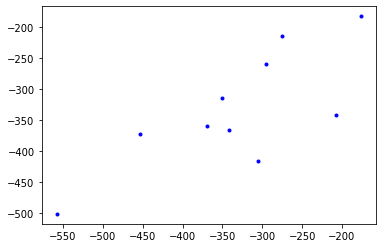

In [22]:
plt.plot(predicted.numpy(), reference.numpy(), 'b.')
print(f"TEST MAE: {test_mae.item()/len(frames[0])} eV/at")

In [23]:
with torch.no_grad():
    tpredicted = []
    treference = []
    for tcomposition, tradial_spectrum, tspherical_expansions, tenergies, _ in train_dataloader:
        treference.append(tenergies)
        predicted_e, _ = model(tcomposition, tradial_spectrum, tspherical_expansions, forward_forces=False)
        tpredicted.append(predicted_e)

    treference = torch.vstack(treference)
    tpredicted = torch.vstack(tpredicted)
    tmae = loss_mae(tpredicted, treference)/n_train

TRAIN MAE: 0.056613723861464745 eV/at


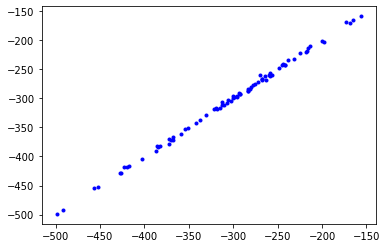

In [24]:
plt.plot(tpredicted, treference, 'b.')
print(f"TRAIN MAE: {tmae.item()/len(frames[0])} eV/at")

# Predicting forces with forward propagation

In [25]:
def evaluate_model_with_forces(model, dataloader):
    predicted_e = []
    reference_e = []
    predicted_f = []
    reference_f = []
    for composition, radial_spectrum, spherical_expansions, energies, forces in dataloader:
        reference_e.append(energies)
        reference_f.append(forces)
        e, f = model(composition, radial_spectrum, spherical_expansions, forward_forces=True)
        predicted_e.append(e)
        predicted_f.append(f)

    reference_e = torch.vstack(reference_e)
    predicted_e = torch.vstack(predicted_e)

    reference_f = torch.vstack(reference_f)
    predicted_f = torch.vstack(predicted_f)

    return reference_e, predicted_e, reference_f, predicted_f

In [26]:
def parity_plots(reference_e, predicted_e, reference_f, predicted_f):
    predicted_e = predicted_e.detach()
    predicted_f = predicted_f.detach()

    fig, (ax_e, ax_f) = plt.subplots(1, 2, figsize=(16, 8))

    mae = loss_mae(predicted_e, reference_e)
    rmse = loss_rmse(predicted_e, reference_e)
    ax_e.scatter(reference_e.cpu(), predicted_e.cpu())
    x = (torch.min(reference_e.flatten()).item(), torch.max(reference_e.flatten()).item())
    ax_e.plot(x, x, color="red")
    ax_e.set_title(f"energies, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_e.set_xlabel("actual")
    ax_e.set_ylabel("predicted")

    mae = loss_mae(predicted_f, reference_f)
    rmse = loss_rmse(predicted_f, reference_f)
    ax_f.scatter(reference_f.cpu(), predicted_f.cpu())
    x = (torch.min(reference_f.flatten()).item(), torch.max(reference_f.flatten()).item())
    ax_f.plot(x, x, color="red")
    ax_f.set_title(f"forces, MAE={mae:.4}, RMSE={rmse:.4}")
    ax_f.set_xlabel("actual")
    ax_f.set_ylabel("predicted")

    return fig

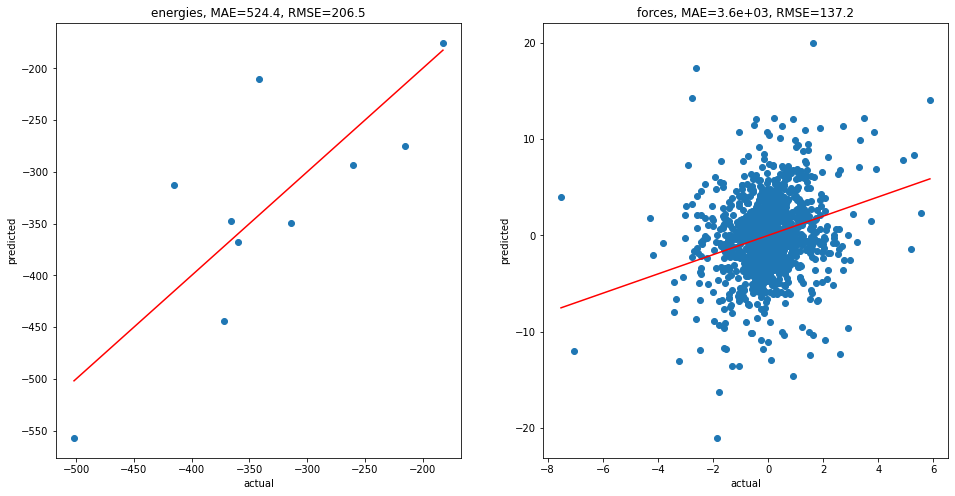

In [29]:
fig = parity_plots(*evaluate_model_with_forces(model, test_dataloader_grad))

In [27]:
def check_finite_differences(model, frame, delta=1e-6):
    frame = frame.copy()
    delta_frame = frame.copy()
    delta_frame.positions[3, 1] += delta

    dataset = AtomisticDataset(
        [frame, delta_frame], 
        all_species, 
        {"radial_spectrum": HYPERS_RAD_GRAD, "spherical_expansion":HYPERS_GRAD}, 
        torch.zeros(2, 1), 
    )
    dataloader = create_dataloader(
        dataset,
        batch_size=len(dataset),
        shuffle=False,
        device=device,
    )

    for frame, radial_spectrum, spherical_expansions, _, _ in dataloader:
        predicted_e, predicted_f = model(frame, radial_spectrum, spherical_expansions, forward_forces=True)

    finite_diff = - (predicted_e[1] - predicted_e[0]) / delta
    print("finite difference =", finite_diff.item())
    print("computed gradient =", predicted_f[3, 1].item())

In [28]:
if torch.get_default_dtype() == torch.float64:
    delta = 1e-6
else:
    delta = 1e-3

check_finite_differences(model, train_frames[22], delta)

finite difference = 7.998683400955997
computed gradient = 7.99868976356426
